# II.5 Valuation

Value your product using your preferred valuation method over a valuation window of at least 100 trading days and compare your (daily) results to (observable) market prices. Calculate appropriate error metrics (e.g. mean error, RMSE, error quantile, etc.). Report your results in a table and comment on your observations.

The chosen Product is a express certificate on the Microsoft stock in USD. The Observation window is 1 year from the 25.06.2024 to the 24.06.2025. The Product does not pay a coupon.

In [1129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import savgol_filter

In [886]:
#Start Date, End Date of the observation window and maturity date of the Express certificate
start_date = pd.to_datetime("2024-06-25")
end_date = pd.to_datetime("2025-06-24")
maturity_date = pd.to_datetime("2027-03-04")

In [1154]:
#read in Express Certificate Data
data = pd.read_csv("./data/Microsoft_express_certificate.csv", delimiter=";")
data["Schluss"] = data['Schluss'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
data['Eröffnung'] = data['Eröffnung'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
data['Hoch'] = data['Hoch'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
data['Tief'] = data['Tief'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
data["Datum"] = pd.to_datetime(data["Datum"], dayfirst=True)

In [1155]:
#read in Microsoft Stock Data
microsoft = pd.read_csv("./data/Microsoft_USD.csv", delimiter=";")
microsoft["Schluss"] = microsoft['Schluss'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Eröffnung'] = microsoft['Eröffnung'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Hoch'] = microsoft['Hoch'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft['Tief'] = microsoft['Tief'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
microsoft["Datum"] = pd.to_datetime(microsoft["Datum"], dayfirst=True)

In [1156]:
## compute volatility (annualized standart deviation)
def compute_observed_volatility(val_close, val_open):
    daily_return = (val_close - val_open) / val_open
    std = np.std(daily_return)
    vola = std * np.sqrt(252)
    return vola

print(compute_observed_volatility(microsoft["Schluss"], microsoft["Eröffnung"]))

0.20834032407713832


In [976]:
#Merge option and stock dataframe into one by date, to only include days, were both have historical data
data.set_index(data["Datum"])
microsoft.set_index(microsoft["Datum"])

stock_option_merged = pd.merge(data[["Datum", "Schluss"]], microsoft[["Datum", "Schluss"]], how="outer", on="Datum")
stock_option_merged = stock_option_merged.dropna()
stock_option_merged = stock_option_merged.sort_values("Datum").reset_index(drop=True)
stock_option_merged.columns = ["Datum", "Option_Price", "Stock_Price"]


In [1157]:
#read in the Parameters for the Svensson Model, downloaded from the Federal Reserve Board.
svensson = pd.read_csv("./data/feds200628.csv", delimiter=",", skiprows=9)
svensson["Date"] = pd.to_datetime(svensson["Date"], dayfirst=False)
svensson = svensson[(svensson["Date"] >= start_date) & (svensson["Date"]<= end_date)].reset_index(inplace=False, drop=True)

In [893]:
#Express Certificate Specifications

NOMINAL        = 1000.0                             # nominal value                              
SHARES         = 2.487                              # 1 cert = 2.487 MSFT shares
BARRIER_PX     = 201.045                            # safety barrier (USD)

LEVELS_PX      = (402.090,                          # auto-call thresholds (USD)
                  402.090,
                  402.090)

THRESHOLD      = 402.090

OBS_DATES      = (pd.to_datetime("2025-03-11"),      # observation dates
                  pd.to_datetime("2026-03-11"),
                  pd.to_datetime("2027-03-11"))   

MATURITY       = pd.to_datetime("2027-03-11")        # maturity date

REPAYMENTS     = (1060.800,                         # repayment values (USD)
                  1121.600,
                  1182.400)

COUPON         = 60.80                              #Coupon paid at observation date. Gets muliplied with number of observation date for final payout


In [1158]:
# Pricing of an express certificate using a binomial tree model
def price_express_certificate(spot,
                               time_to_maturity,
                               sigma,
                               val_date,
                               r_vec,
                               dividend):

    # Time step in years (assuming 252 trading days)
    dt = 1 / 252
    n_days = int(time_to_maturity * 252)  # total number of time steps
    idx_of = lambda d: (d - val_date).days  # maps a date to a time step index

    # Map each observation date to its index and store the corresponding payoff barrier level
    obs_idx = {}
    for obs_d, level_px in zip(OBS_DATES, LEVELS_PX):
        if obs_d < val_date:
            continue
        o_i = idx_of(obs_d)
        if 0 <= o_i < n_days:
            obs_idx[o_i] = level_px

    # Binomial tree parameters
    u = np.exp(sigma * np.sqrt(dt))                     # up factor
    d = 1.0 / u                                          # down factor
    p = (np.exp((r_vec - dividend) * dt) - d) / (u - d)  # risk-neutral up probability
    p_d = 1 - p                                          # down probability

    # Build the stock price tree S[i][j]: price at time i after j up moves
    S = [[spot * (u ** j) * (d ** (i - j)) for j in range(i + 1)]
         for i in range(n_days + 1)]

    # Initialize option value tree V[i][j] with zero
    V = [[0.0] * (i + 1) for i in range(n_days + 1)]

    # Terminal payoff at maturity (based on final stock price)
    for j, ST in enumerate(S[-1]):
        if BARRIER_PX <= ST < THRESHOLD:
            V[-1][j] = NOMINAL                           # barrier breached but threshold not reached
        elif ST < BARRIER_PX:
            V[-1][j] = SHARES * ST                       # worst-case: below barrier, deliver shares
        else:
            V[-1][j] = NOMINAL + 3 * COUPON              # full redemption with maximum coupons

    # Track whether certificate has been redeemed early
    redeemed = [[False] * (i + 1) for i in range(n_days + 1)]

    # Backward induction through the tree
    for i in range(n_days - 1, -1, -1):
        is_obs = i in obs_idx  # check if it's an observation date
        for j in range(i + 1):
            if is_obs and S[i][j] >= obs_idx[i]:
                # Early redemption: stock above barrier → payoff now
                obs_number = list(sorted(obs_idx)).index(i) + 1
                V[i][j] = NOMINAL + obs_number * COUPON
                redeemed[i][j] = True
                continue
            elif redeemed[i][j]:
                # Already redeemed
                continue
            else:
                # Expected discounted value from continuation
                V[i][j] = np.exp(-(r_vec - dividend) * dt) * (
                    p * V[i + 1][j + 1] + p_d * V[i + 1][j]
                )

    # Compute greeks at initial time
    # Delta: sensitivity to spot price
    delta = (V[1][0] - V[1][1]) / (S[1][0] - S[1][1])

    # Gamma: second-order sensitivity to spot
    delta_up   = (V[2][2] - V[2][1]) / (S[2][2] - S[2][1])
    delta_down = (V[2][1] - V[2][0]) / (S[2][1] - S[2][0])
    gamma      = (delta_up - delta_down) / ((S[2][2] - S[2][0]) / 2)

    # Theta: sensitivity to time (per two time steps)
    theta = (V[2][1] - V[0][0]) / (2 * dt)

    return V[0][0], delta, gamma, theta  # Return price and greeks


In [895]:
## compute risk-free rate using the svenson method
def svensson_spot_rate(t, beta0, beta1, beta2, beta3, tau1, tau2):
    """
    Compute the spot rate y(t) using the Svensson yield curve model.

    Parameters:
    - t: time to maturity (in years)
    - beta0, beta1, beta2, beta3: Svensson parameters
    - tau1, tau2: decay parameters

    Returns:
    - spot rate y(t)
    """
    term1 = (1 - np.exp(-t / tau1)) / (t / tau1)
    term2 = term1 - np.exp(-t / tau1)
    term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)

    y_t = beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3
    r_t = y_t / 100

    return r_t

In [912]:
# Initialize lists to store computed values for each trading day
daily_option_values = []  # List to store the value of the express certificate each day
daily_risk_rate = []      # List to store the corresponding daily risk-free interest rate
deltas = []               # List to store the delta of the certificate

# Loop over each day in the stock-option merged DataFrame
for day in range(0, stock_option_merged.shape[0]):
    
    # Extract and parse the current date
    current_date = pd.to_datetime(stock_option_merged.iloc[day]["Datum"])
    
    # Calculate the time to maturity in years from the current date
    time_to_maturity = (maturity_date - current_date).days / 365

    # Retrieve relevant market data for the day
    volatility = 0.20834  # Average annualized volatility of Microsoft stock
    S0_t = stock_option_merged.iloc[day]["Stock_Price"]  # Current stock price

    # Get Svensson model parameters for yield curve interpolation
    svensson_params = svensson[svensson["Date"] == current_date]
    
    if svensson_params.empty:
        # Fallback if no rate is available for the current date
        r_t = 0.04
    else: 
        # Compute spot rate using Svensson model
        r_t = svensson_spot_rate(
            time_to_maturity,
            svensson_params["BETA0"],
            svensson_params["BETA1"],
            svensson_params["BETA2"],
            svensson_params["BETA3"],
            svensson_params["TAU1"],
            svensson_params["TAU2"]
        )
        r_t = float(r_t.iloc[0])  # Extract scalar from single-row DataFrame
    
    # Store the current risk-free rate
    daily_risk_rate.append(r_t)
    
    # Compute certificate value and delta (ignoring gamma and theta for now)
    value_t, delta, _, _ = price_express_certificate(
        spot=S0_t,
        time_to_maturity=time_to_maturity,
        sigma=volatility,
        val_date=current_date,
        r_vec=r_t,
        dividend=0.006  # Annual dividend yield of Microsoft
    )

    # Store the option value and delta for the day
    daily_option_values.append(value_t)
    deltas.append(delta)

# Convert results to DataFrames for further processing or plotting
daily_option_values = pd.DataFrame(daily_option_values)
daily_risk_rate = pd.DataFrame(daily_risk_rate)
deltas = pd.DataFrame(deltas)


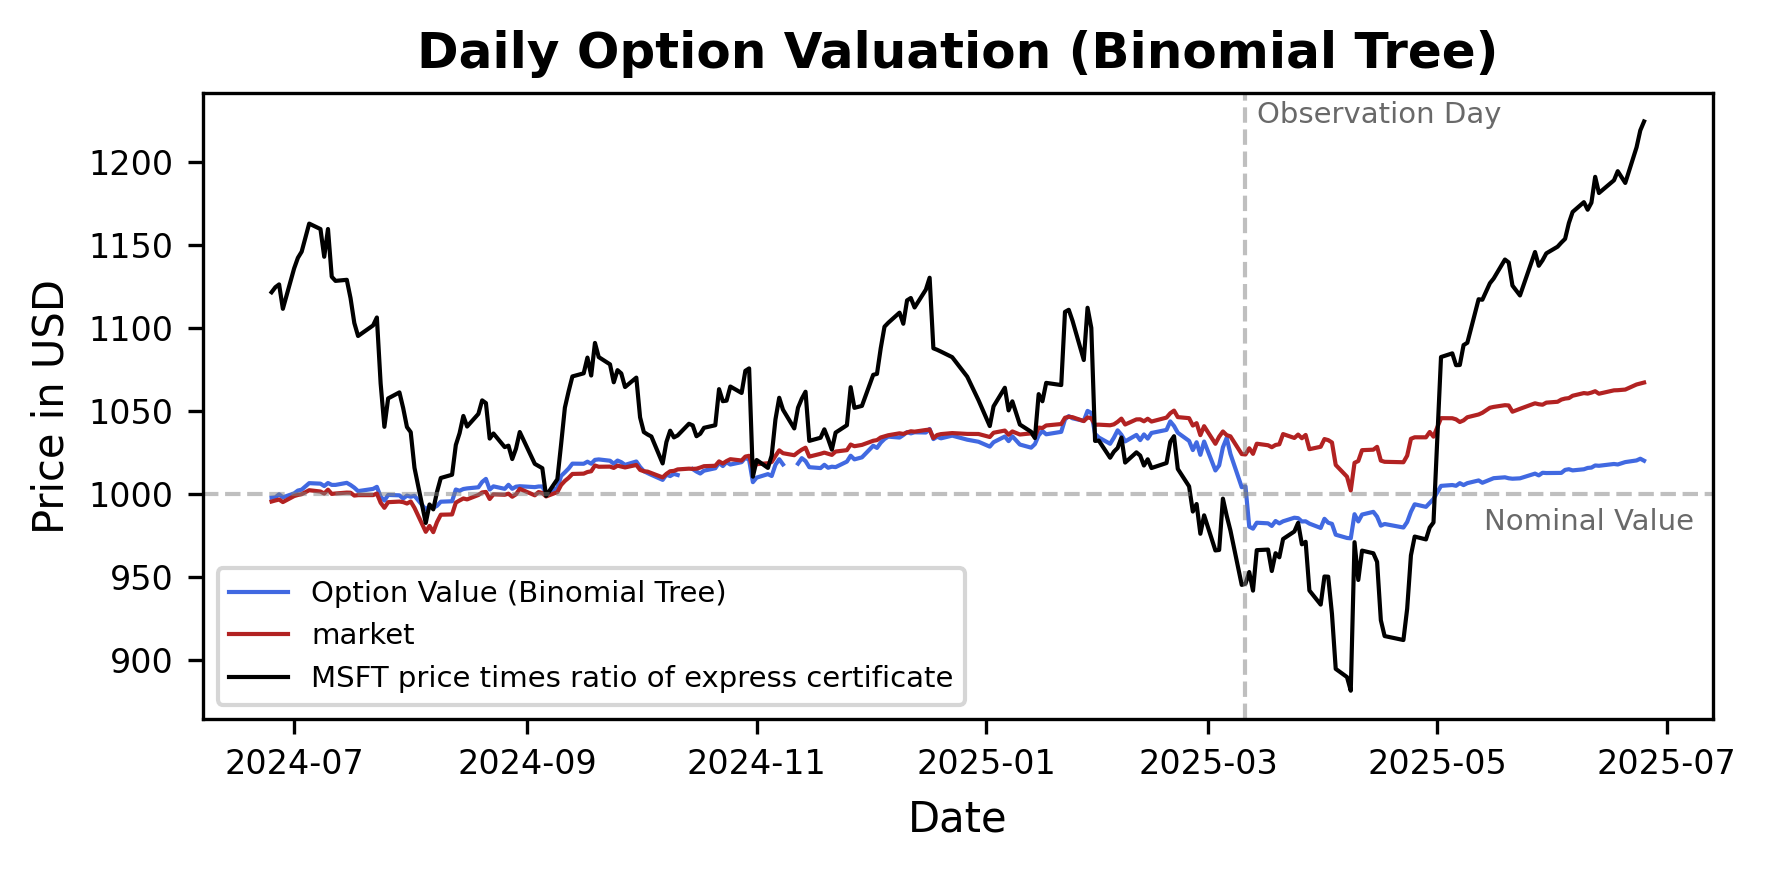

In [1142]:
#Plot the Valuation over time in comparison to the real market price of the Express Certificate and the Stock Price
plt.figure(figsize=(6, 3), dpi=300)

plt.plot(stock_option_merged["Datum"], daily_option_values, label="Option Value (Binomial Tree)", color="royalblue",  linewidth=1)
plt.plot(stock_option_merged["Datum"], stock_option_merged["Option_Price"], label="market", color="firebrick",  linewidth=1)
plt.plot(stock_option_merged["Datum"], stock_option_merged["Stock_Price"]*SHARES, label = "MSFT price times ratio of express certificate", color ="black" , linewidth=1)

plt.axhline(NOMINAL, color="grey", linestyle="--", linewidth=1, alpha=0.5)
plt.text(
    plt.gca().get_xlim()[1]-5,  NOMINAL -25, 
    "Nominal Value",
    color="dimgrey", fontsize=7, va="bottom", ha="right"
)

plt.axvline(OBS_DATES[0], color="grey", linestyle="--", linewidth=1, alpha=0.5)
plt.text(
    OBS_DATES[0] + pd.Timedelta(days=3), plt.gca().get_ylim()[1] -5, 
    "Observation Day",
    color="dimgrey", fontsize=7, rotation=0, va="top", ha="left"
)

plt.title("Daily Option Valuation (Binomial Tree)", fontsize=12, fontweight='bold')
plt.xlabel("Date",fontsize=10)
plt.ylabel("Price in USD", fontsize=10)
plt.grid(False)
plt.tick_params("both", labelsize =8)
plt.legend(
    loc='lower left',       
    fontsize=7,     
    frameon=True            
)
plt.tight_layout()
plt.show()

In [1100]:
#Compute error metrics to compare Valuation of the Express Certificate with the observed market prices.
stock_option_merged["Valuation_Price"] = daily_option_values

# 1. Raw error
errors = stock_option_merged["Valuation_Price"] - stock_option_merged["Option_Price"]

# 2. Mean Error (ME)
mean_error = errors.mean()

#2. Mean squared error (MSE)
mean_squared_error = (errors**2).mean()

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt((errors ** 2).mean())

# 4. Mean Absolute Error (MAE)
mae = errors.abs().mean()

# 5. Relative error (percentage)
relative_errors = errors / stock_option_merged["Option_Price"]

# 6. Mean Absolute Percentage Error (MAPE)
mape = relative_errors.abs().mean() * 100

# 7. Error quantiles
quantiles = errors.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

# 8. Max deviation
max_error = errors.abs().max()
max_error_date = errors.abs().idxmax()

# Print summary
print("Mean Error (ME):", mean_error)
print("Mean Error (MSE):", mean_squared_error)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Error Quantiles:")
print(quantiles)
print("Max Absolute Error: {:.2f} on {}".format(max_error, max_error_date))


Mean Error (ME): -13.155899710735033
Mean Error (MSE): 560.9192769258826
Root Mean Squared Error (RMSE): 23.68373443791926
Mean Absolute Error (MAE): 15.935757436424872
Mean Absolute Percentage Error (MAPE): 1.54%
Error Quantiles:
0.05   -47.168669
0.25   -37.791677
0.50    -4.808241
0.75     2.440353
0.95     6.202923
dtype: float64
Max Absolute Error: 52.48 on 181


## II.3 Replicating Portfolio
Determine the replicating portfolio for your product for each day within your observation window. Additionally, illustrate the equity fraction as a function of the price of the underlying at a specific point in time. Interpret your results in terms of the characteristics of your product in falling markets.

In [860]:
#Create a Dataframe with Date and Price for Express certificate and Stock Price to model replicating portfolio
stock_price = microsoft[["Datum","Schluss"]]
option_value = data[["Datum","Schluss"]]

stock_price.set_index(stock_price["Datum"])
option_value.set_index(option_value["Datum"])

stock_option = pd.merge(stock_price, option_value, how="outer", on="Datum")
stock_option = stock_option.dropna()
stock_option = stock_option.sort_values("Datum").reset_index(drop=True)

#use the deltas computed with the binomial tree for each day in the observation window.
stock_option["delta"] = deltas

In [861]:
#Calculate the Bond component
def compute_bond(deltas, stock_price, option_value):
    stock_price = np.array(stock_price)
    option_value = np.array(option_value)
    deltas = np.array(deltas)

    bond = np.zeros_like(option_value)
    bond = (option_value - deltas.T * stock_price).T
    return pd.DataFrame(bond)


In [862]:
bond_val = compute_bond(stock_option["delta"], stock_option["Schluss_x"], stock_option["Schluss_y"])

In [865]:
#compute relevant Fractions, given the Equity Value and Bond Value calculated.
stock_option["bond_value"] = bond_val
stock_option["portfolio_value"] = stock_option["delta"] * stock_option["Schluss_x"] + stock_option["bond_value"]
stock_option["equity_value"] = stock_option["delta"] * stock_option["Schluss_x"]
stock_option["equity_fraction"] = stock_option["equity_value"] / stock_option["portfolio_value"]
stock_option["bond_fraction"] = stock_option["bond_value"] / stock_option["portfolio_value"]
stock_option.head(20)

,Datum,Schluss_x,Schluss_y,delta,bond_value,portfolio_value,equity_value,equity_fraction,bond_fraction
0,2024-06-25,450.950,995.62,0.315727,853.242912,995.62,142.377088,0.143003,0.856997
1,2024-06-26,452.160,996.25,0.312084,855.137962,996.25,141.112038,0.141643,0.858357
2,2024-06-27,452.850,996.80,0.301811,860.124840,996.80,136.675160,0.137114,0.862886
3,2024-06-28,446.950,995.28,0.325989,849.579108,995.28,145.700892,0.146392,0.853608
4,2024-07-01,456.730,998.89,0.290274,866.313162,998.89,132.576838,0.132724,0.867276
5,2024-07-02,459.280,999.56,0.270985,875.102010,999.56,124.457990,0.124513,0.875487
6,2024-07-03,460.770,1000.03,0.273382,874.063917,1000.03,125.966083,0.125962,0.874038
7,2024-07-05,467.560,1002.42,0.244576,888.066065,1002.42,114.353935,0.114078,0.885922
8,2024-07-08,466.240,1001.62,0.250836,884.670146,1001.62,116.949854,0.116761,0.883239
9,2024-07-09,459.540,1000.41,0.272590,875.144035,1000.41,125.265965,0.125215,0.874785


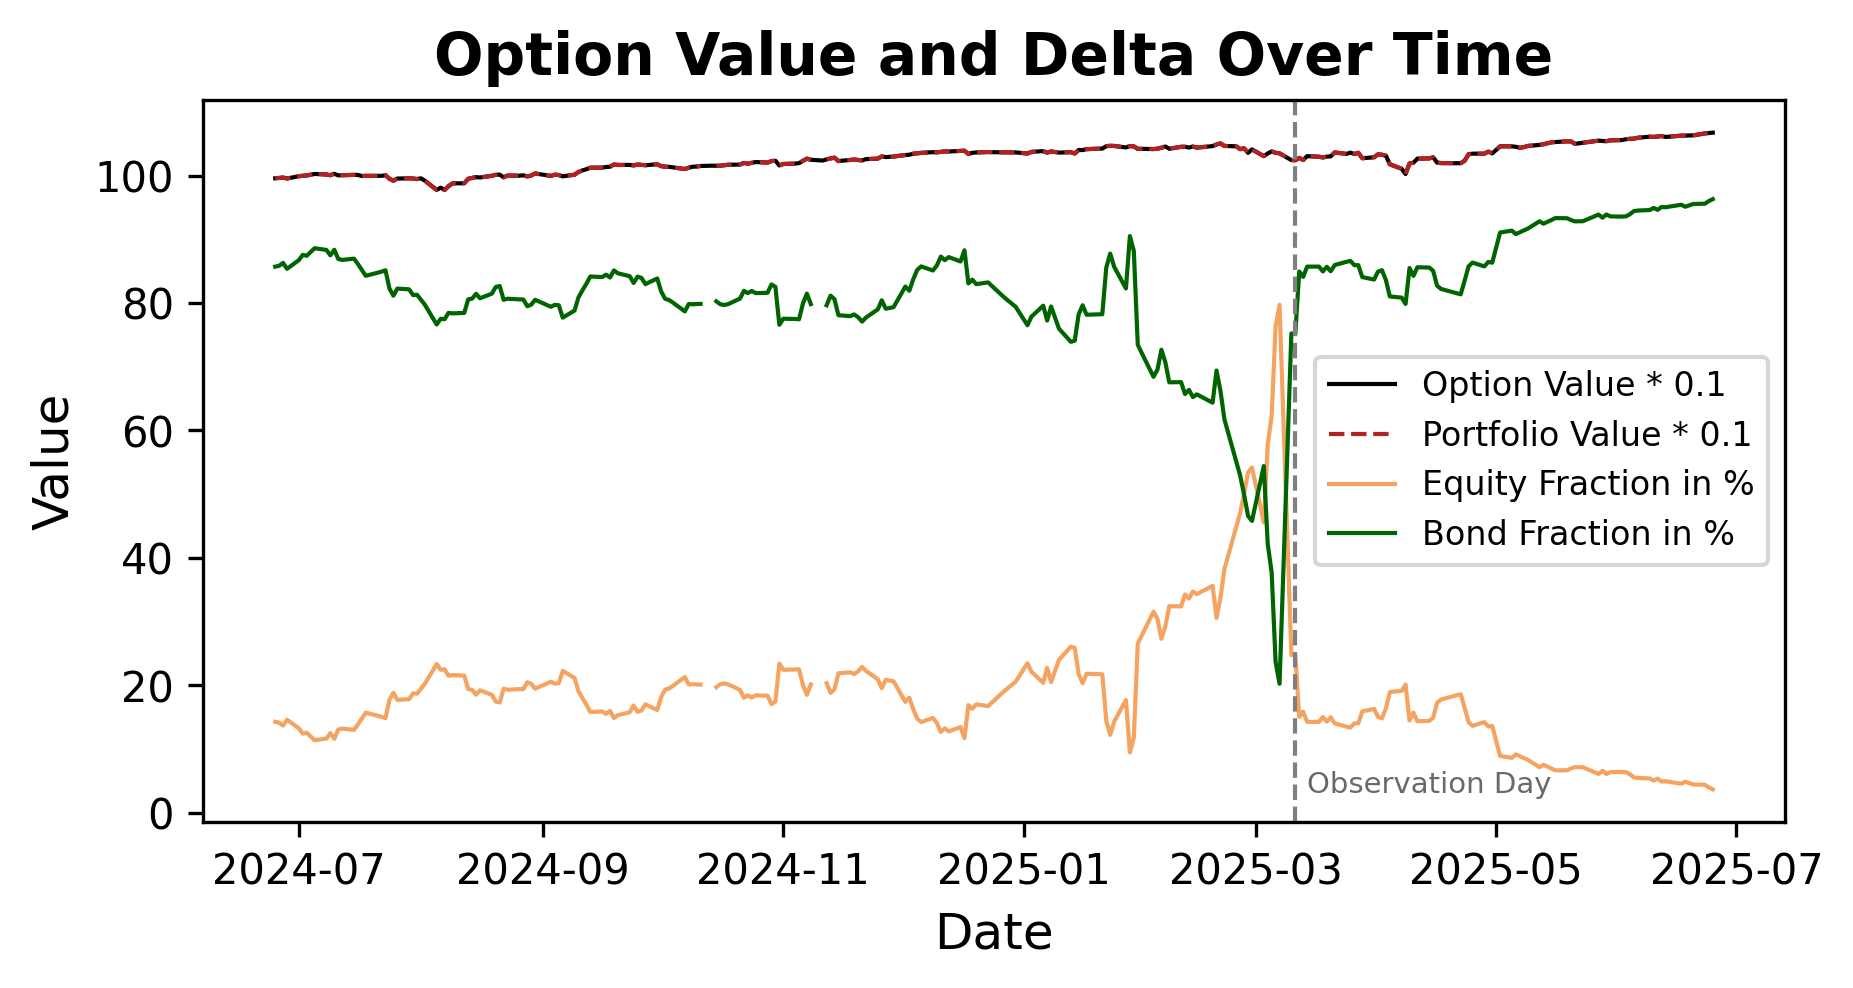

In [1151]:
#visualize Replicating Portfolio with the actual market value of the Certificate. Additionally plot the equity and Bond Fraction.
fig, ax1 = plt.subplots(figsize = (6,3), dpi=300)
fig.tight_layout()

ax1.plot(stock_option["Datum"],stock_option["Schluss_y"]/10 , label="Option Value * 0.1", color="black",  linewidth=1)
ax1.plot(stock_option["Datum"], stock_option["portfolio_value"]/10, label="Portfolio Value * 0.1", color="firebrick", linestyle = "--",  linewidth=1)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Value", color="black", fontsize=12)
ax1.plot(stock_option["Datum"], stock_option["equity_fraction"]*100, label="Equity Fraction in %", color="sandybrown" , linewidth=1)
ax1.plot(stock_option["Datum"], stock_option["bond_fraction"]*100, label="Bond Fraction in %", color="darkgreen", linewidth=1)

plt.axvline(OBS_DATES[0], color="grey", linestyle="--", linewidth=1)
plt.text(
    OBS_DATES[0] + pd.Timedelta(days=3), plt.gca().get_ylim()[0] +8,
    "Observation Day",
    color="dimgrey", fontsize=7, rotation=0, va="top", ha="left"
)

metrics = {
    'equity_fraction': ('orange', 'Equity Fraction'),
    'bond_fraction': ('green', 'Bond Fraction'),
    'Schluss_y': ('black', 'Option Value'),
    'portfolio_value': ('red', 'Portfolio Value'),

}

plt.title("Option Value and Delta Over Time", fontsize=14, fontweight='bold')
plt.tick_params("both", labelsize =10)
plt.legend(
    fontsize=8, 
    frameon=True          
)
plt.show()

In [1003]:
#Plot Equity Fraction for the 03-03-2025 (same as the greeks)

#specified date to compute the equity fraction
date = pd.to_datetime("2025-03-03")

index = stock_option[stock_option["Datum"] == date].index[0]

#compute time to maturity for the specified date
time_to_maturity = (maturity_date - date).days / 365

#compute the risk free rate at specified date using the svensson method
svensson_params = svensson[svensson["Date"] == date]
riske_free_rate = svensson_spot_rate(time_to_maturity, svensson_params["BETA0"], svensson_params["BETA1"], svensson_params["BETA2"], svensson_params["BETA3"], svensson_params["TAU1"], svensson_params["TAU2"])      
r_t = riske_free_rate.values[0]

#observed volatility of the observation window
volatility = 0.208

#Compute Delta over varying Stock Price
deltas_over_stock_equity = []

stock_prices = np.linspace(150, 500, 400)

for price in stock_prices:
    S0_t = price
    value_t, delta, gamma, theta = price_express_certificate(spot=S0_t, time_to_maturity=time_to_maturity, sigma = volatility, val_date = date, r_vec = r_t, dividend=0.006 )
    deltas_over_stock_equity.append(delta)

deltas_over_stock_equity = pd.DataFrame(deltas_over_stock_equity)

Text(417.09, 0.8179950465571177, 'Visualized Date:\n  03-03-2025')

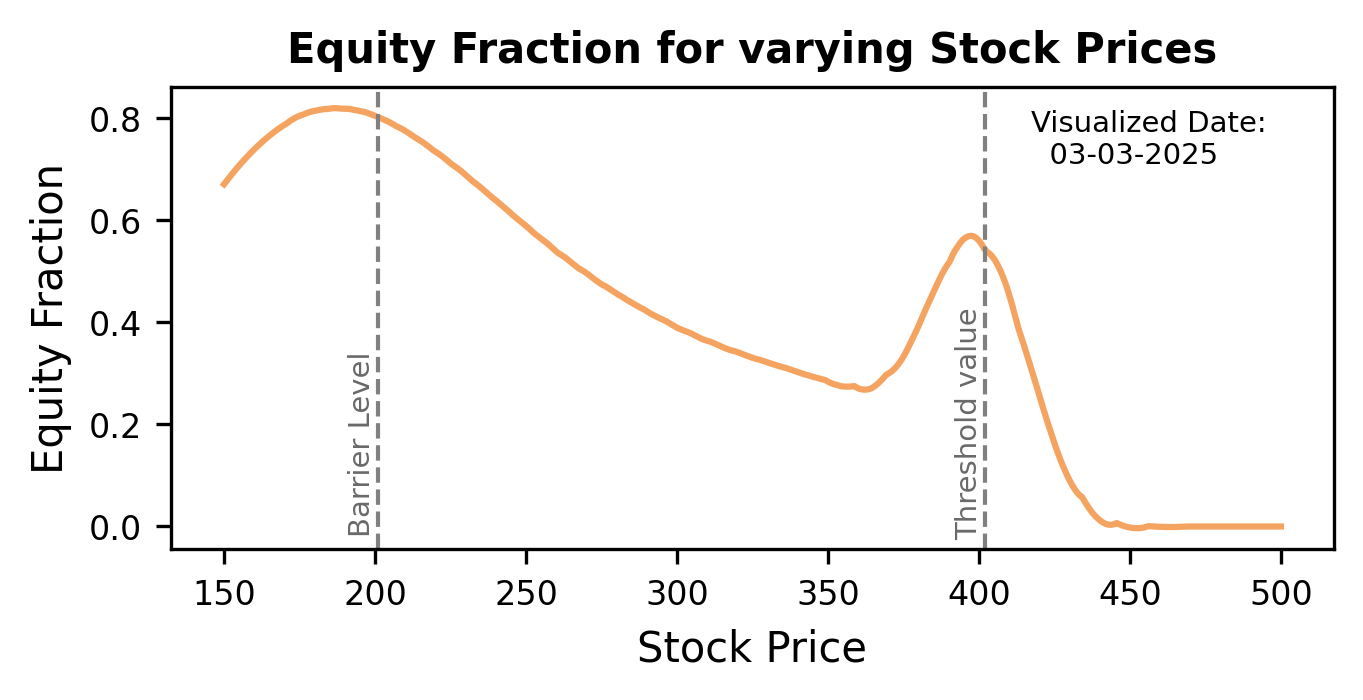

In [1152]:
#visualize equity Fraction given Stock Price. 

bond_value_at_date = stock_option[stock_option["Datum"] == date]["Schluss_y"].values[0]

equity_value_fixed_day= deltas_over_stock_equity * pd.DataFrame(stock_prices)
equity_fraction_fixed_day = equity_value_fixed_day / bond_value_at_date

smoothed_equity_fraction_fixed_day = savgol_filter(equity_fraction_fixed_day[0], 50, 3)

plt.figure(figsize=(5, 2), dpi=300)
plt.plot(stock_prices, smoothed_equity_fraction_fixed_day, color="sandybrown")
plt.axvline(THRESHOLD, color="grey", linestyle="--", linewidth=1)
plt.axvline(BARRIER_PX, color="grey", linestyle="--", linewidth=1)
plt.xlabel("Stock Price", fontsize=10)
plt.ylabel("Equity Fraction", fontsize =10)
plt.tick_params("both", labelsize = 8)
plt.title("Equity Fraction for varying Stock Prices",fontsize=10, fontweight='bold')

plt.text(
    BARRIER_PX - 10,  # Slightly to the right of the line
    plt.ylim()[1] * 0.40,  # Near the top of the y-axis
    "Barrier Level",
    rotation=90,
    fontsize = 7,
    verticalalignment='top',
    color="dimgrey"
)

plt.text(
    THRESHOLD - 10,  # Slightly to the right of the line
    plt.ylim()[1] * 0.5,  # Near the top of the y-axis
    "Threshold value",
    rotation=90,
    fontsize = 7,
    verticalalignment='top',
    color="dimgrey"
)

plt.text(
    THRESHOLD+15,  # Slightly to the right of the line
    plt.ylim()[1] * 0.95,  # Near the top of the y-axis
    "Visualized Date:\n  03-03-2025",
    fontsize = 7,
    verticalalignment='top',
    color="black"
)

## II.2 Sensitivity Analysis

Conduct a thorough sensitivity analysis of your product towards the most relevant parameters. To do so, plot the greeks (Delta, Gamma, Vega, etc.) of your product and discuss your observations. You are free to choose either fictitious or actual observed parameters. Anyway, all inputs must be sensible.

The Greeks are visualized for the 03.03.2025, so a date close to the observation date.

In [978]:
#Compute Delta and Gamma over Stock Price
deltas_over_stock = []
gammas_over_stock =[]
theta_over_stock = []

#specified date to observe greeks
date = pd.to_datetime("2025-03-03")

index = stock_option[stock_option["Datum"] == date].index[0]

#compute time to maturity for the specified date
time_to_maturity = (maturity_date - date).days / 365

#compute the risk free rate at specified date using the svensson method
svensson_params = svensson[svensson["Date"] == date]
svensson = svensson_spot_rate(time_to_maturity, svensson_params["BETA0"], svensson_params["BETA1"], svensson_params["BETA2"], svensson_params["BETA3"], svensson_params["TAU1"], svensson_params["TAU2"])      
r_t = svensson.values[0]
volatility = 0.208 #observed volatility of the observation window

stock_prices = np.linspace(150, 500, 400)

for price in stock_prices:
    S0_t = price
    value_t, delta, gamma, theta = price_express_certificate(spot=S0_t, time_to_maturity=time_to_maturity, sigma = volatility, val_date = date, r_vec = r_t, dividend=0.006 )
    deltas_over_stock.append(delta)
    gammas_over_stock.append(gamma)
    theta_over_stock.append(theta)

deltas_over_stock = pd.DataFrame(deltas_over_stock)
gammas_over_stock = pd.DataFrame(gammas_over_stock)
theta_over_stock = pd.DataFrame(theta_over_stock)

In [979]:
#smooth graphs for visualization
smoothed_deltas = np.array(deltas_over_stock)
smoothed_gammas = np.array(gammas_over_stock)
smoothed_thetas = np.array(theta_over_stock)

smoothed_deltas = savgol_filter(deltas_over_stock[0], 50, 3)
smoothed_gammas = savgol_filter(gammas_over_stock[0], 50, 3)
smoothed_thetas = savgol_filter(theta_over_stock[0], 50, 3)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, dpi=300)
fig.suptitle("Greeks of the Express Certificate", fontsize=12, fontweight='bold')

# --- Subplot 1: Delta ---
axes[0].plot(stock_prices, deltas_over_stock , color="blue", linewidth=1)
axes[0].plot(stock_prices, smoothed_deltas, label="Delta", color="red", linewidth=1)
#axes[0].set_title("Delta", fontsize=10)
axes[0].set_xlabel("MSFT Price")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[0].legend(loc='upper right', fontsize='x-small')

# --- Subplot 2: Gamma ---
axes[1].plot(stock_prices, gammas_over_stock, color="blue", linewidth=1)
axes[1].plot(stock_prices, smoothed_gammas, label="Gamma", color="red", linewidth=1)
#axes[1].set_title("Gamma", fontsize=10)
axes[1].set_xlabel("MSFT Price")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[1].legend(loc='upper right', fontsize='x-small')

# --- Subplot 3: Theta ---
axes[2].plot(stock_prices, theta_over_stock, color="blue", linewidth=1)
axes[2].plot(stock_prices, smoothed_thetas, label="Theta", color="red", linewidth=1)
#axes[2].set_title("Theta", fontsize=10)
axes[2].set_xlabel("MSFT Price")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[2].legend(loc='upper right', fontsize='x-small')

# Tight layout for spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [984]:
#Compute Vega using Binomial Tree
option_values_given_vola = []

date = pd.to_datetime("2025-03-03")

index = stock_option[stock_option["Datum"] == date].index[0]

time_to_maturity = (maturity_date - date).days / 365 # time to maturity (in years)

r_t = r_t

#varying volatilites to compute the Vega
volatilities = [0.2 , 0.200001]

for price in stock_prices:
    
    S0_t = price
    value_vola = []

    for vola in volatilities:

        volatility = vola
        value_t, _, _, _ = price_express_certificate(spot=S0_t, time_to_maturity=time_to_maturity, sigma = volatility, val_date = current_date, r_vec = r_t, dividend=0.006 )
        value_vola.append(value_t)
    
    option_values_given_vola.append(value_vola)

option_values_given_vola = pd.DataFrame(option_values_given_vola)



In [985]:
vegas = (option_values_given_vola[0] - option_values_given_vola[1])/ (volatilities[0] - volatilities[1])
smoothed_vegas = savgol_filter(vegas, 50, 3)

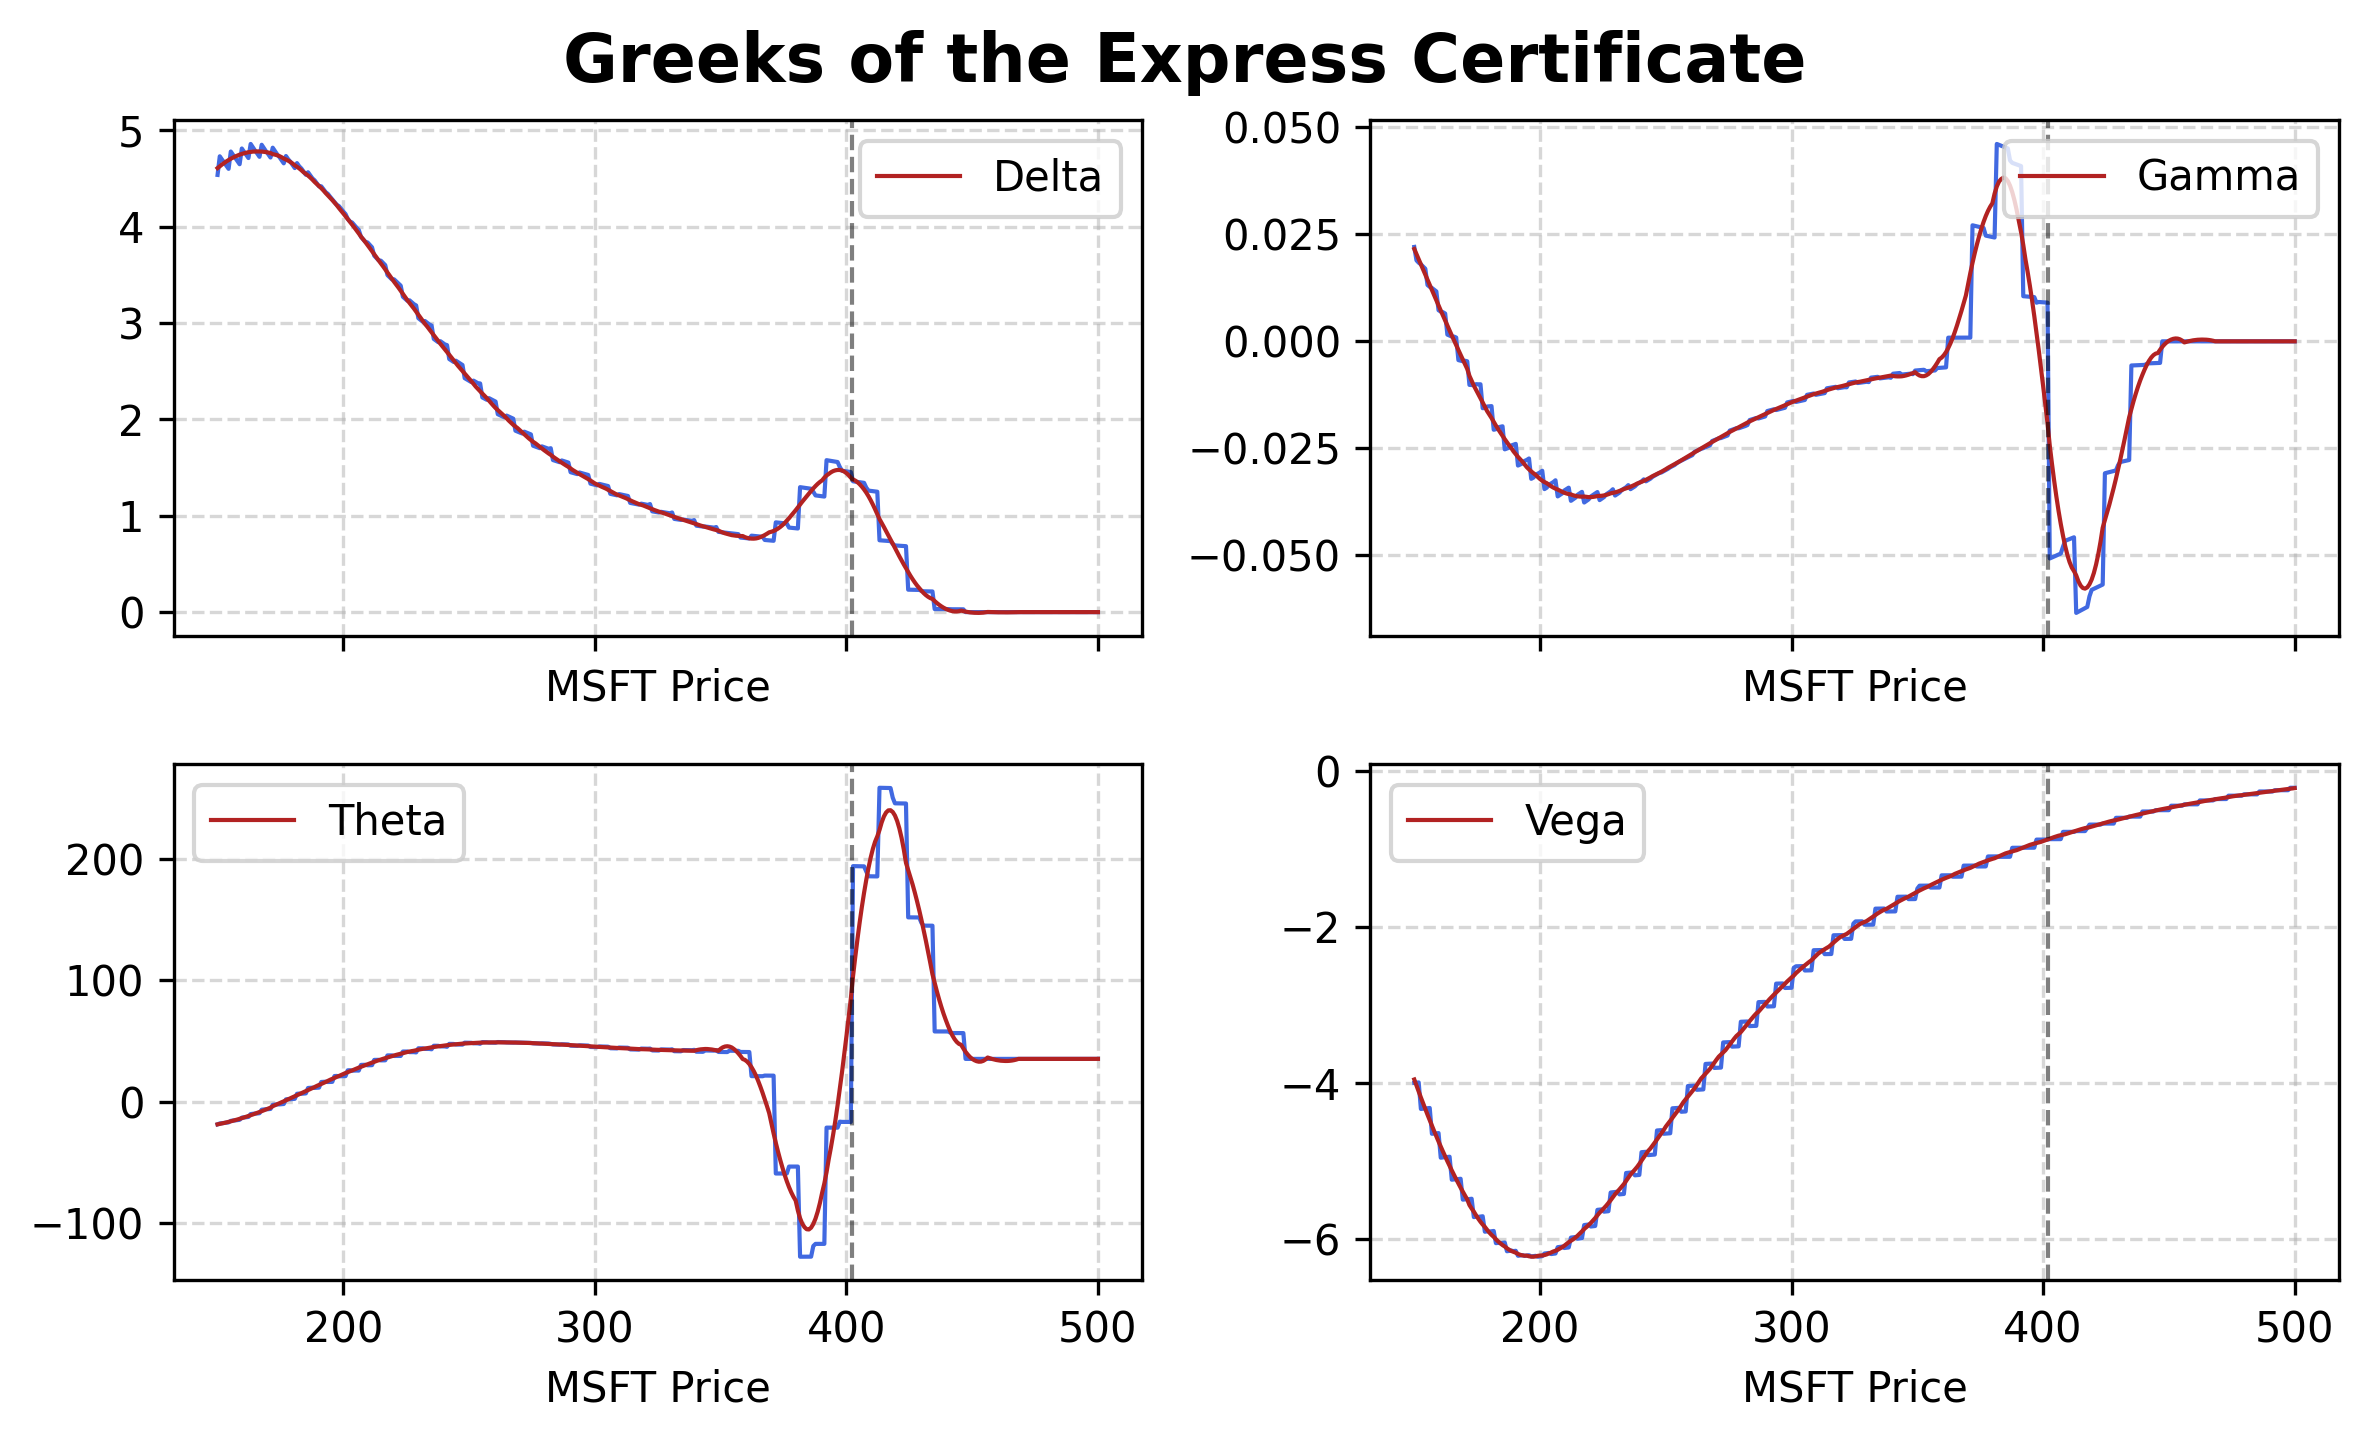

In [1153]:
#Visualize the Greeks given Stock price. 
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, dpi=300)

# --- Subplot 1: Delta ---
axes[0,0].plot(stock_prices, deltas_over_stock , color="royalblue", linewidth=1)
axes[0,0].plot(stock_prices, smoothed_deltas, label="Delta", color="firebrick", linewidth=1)
axes[0,0].set_xlabel("MSFT Price", fontsize=10)
axes[0,0].grid(True, linestyle='--', alpha=0.5)
axes[0,0].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[0,0].legend(loc='upper right')

# --- Subplot 2: Gamma ---
axes[0,1].plot(stock_prices, gammas_over_stock, color="royalblue", linewidth=1)
axes[0,1].plot(stock_prices, smoothed_gammas, label="Gamma", color="firebrick", linewidth=1)
#axes[1].set_title("Gamma", fontsize=10)
axes[0,1].set_xlabel("MSFT Price", fontsize=10)
axes[0,1].grid(True, linestyle='--', alpha=0.5)
axes[0,1].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[0,1].legend(loc='upper right')

# --- Subplot 3: Theta ---
axes[1,0].plot(stock_prices, theta_over_stock, color="royalblue", linewidth=1)
axes[1,0].plot(stock_prices, smoothed_thetas, label="Theta", color="firebrick", linewidth=1)
#axes[2].set_title("Theta", fontsize=10)
axes[1,0].set_xlabel("MSFT Price")
axes[1,0].grid(True, linestyle='--', alpha=0.5)
axes[1,0].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[1,0].legend(loc='upper left')

# --- Subplot 4: Vega ---
axes[1,1].plot(stock_prices, vegas/100, color="royalblue", linewidth=1)
axes[1,1].plot(stock_prices, smoothed_vegas/100, label="Vega", color="firebrick", linewidth=1)
#axes[3].set_title("Theta", fontsize=10)
axes[1,1].set_xlabel("MSFT Price", fontsize=10)
axes[1,1].grid(True, linestyle='--', alpha=0.5)
axes[1,1].axvline(THRESHOLD, linestyle="--", color="black", alpha = 0.5, linewidth = 1)
axes[1,1].legend(loc='upper left')


# Tight layout for spacing
fig.suptitle("Greeks of the Express Certificate", fontsize=16, fontweight='bold')
#plt.tick_params("both", labelsize = 8)
plt.tight_layout(rect=[0, 0.03, 1, 1.03])
plt.show()